[![image](https://jupyterlite.rtfd.io/en/latest/_static/badge.svg)](https://demo.leafmap.org/lab/index.html?path=maplibre/AlphaEarth.ipynb)
[![image](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/opengeos/leafmap/blob/master/docs/maplibre/AlphaEarth.ipynb)
[![image](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/opengeos/leafmap/HEAD)

**Visualize AlphaEarth satellite embeddings in 3D**

Google DeepMind has released a new satellite embedding dataset called AlphaEarth. This dataset contains annual satellite embeddings from 2017 to 2024, with each pixel representing a 10x10 meter area. The dataset is available on Google Earth Engine, and can be used to train machine learning models to classify satellite imagery.

- News release: https://deepmind.google/discover/blog/alphaearth-foundations-helps-map-our-planet-in-unprecedented-detail/
- Dataset: https://developers.google.com/earth-engine/datasets/catalog/GOOGLE_SATELLITE_EMBEDDING_V1_ANNUAL#description
- Paper: https://storage.googleapis.com/deepmind-media/DeepMind.com/Blog/alphaearth-foundations-helps-map-our-planet-in-unprecedented-detail/alphaearth-foundations.pdf
- Blog post: https://medium.com/google-earth/ai-powered-pixels-introducing-googles-satellite-embedding-dataset-31744c1f4650
- Tutorials: https://developers.google.com/earth-engine/tutorials/community/satellite-embedding-01-introduction
- Similarity search: https://earthengine-ai.projects.earthengine.app/view/embedding-similarity-search
- Clustering: https://code.earthengine.google.com/b0871454add885294f633f731b90f946


Uncomment the following line to install [leafmap](https://leafmap.org) if needed.

In [4]:
%pip install -U leafmap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 603.9/603.9 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.7/207.7 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 45.7 MB/s eta 0:00:00


In [5]:
import ee
import leafmap.maplibregl as leafmap
ee.Authenticate()
ee.Initialize(project='alphaearth-87140')

To use the AlphaEarth satellite embeddings, you will need to authenticate with Earth Engine.

If you don't have an Earth Engine account, you can create one at https://earthengine.google.com.

Once you have an Earth Engine account, you can authenticate with Earth Engine by running the following code:

In [12]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/gee_exports/Arizona_tif_centers.csv')
df.head()

,filename,center_lon,center_lat
0,/project/biocomplexity/wyr6fx(Nibir)/NeurIPS_i...,-109.704294,31.596059
1,/project/biocomplexity/wyr6fx(Nibir)/NeurIPS_i...,-109.671294,31.823753
2,/project/biocomplexity/wyr6fx(Nibir)/NeurIPS_i...,-109.747793,31.570351
3,/project/biocomplexity/wyr6fx(Nibir)/NeurIPS_i...,-109.700888,31.576143
4,/project/biocomplexity/wyr6fx(Nibir)/NeurIPS_i...,-109.630775,31.727080


In [ ]:
import ee
import pandas as pd
import geemap
import os

# --- Initialize ---
ee.Initialize(project='alphaearth-87140')

# --- Input CSV ---
csv_path = "/content/drive/MyDrive/gee_exports/Arizona_tif_centers_with_paths.csv"
df = pd.read_csv(csv_path)

# --- AlphaEarth collection (64-D embeddings) ---
coll = ee.ImageCollection("GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL")

def find_image(point):
    """Get the first AlphaEarth image covering the point."""
    return coll.filterDate("2017-01-01", "2024-01-01").filterBounds(point).first()

# --- Prepare output directory ---
out_dir = "/content/drive/MyDrive/gee_exports"
os.makedirs(out_dir, exist_ok=True)

# --- Add column to store exported file path ---
df["tif_path"] = None
s_idx = 3000

# --- Export loop (small batch for test) ---
for i, row in df.head(5000).iterrows():   # change .head(3) → .iterrows() for all rows
    if i < s_idx:
        continue
    lon, lat = float(row.center_lon), float(row.center_lat)
    point = ee.Geometry.Point(lon, lat)
    print(f"\nRow {i}: ({lon:.4f}, {lat:.4f})")

    img = find_image(point)
    if img:
        out_path = os.path.join(out_dir, f"alphaearth_image_{i}.tif")

        try:
            geemap.ee_export_image(
                img,
                filename=out_path,
                scale=10,
                region=point.buffer(1120).bounds(),  # roughly 224×224 at 10m scale
                file_per_band=False
            )
            df.at[i, "tif_path"] = out_path
            print(f"✅ Exported: {out_path}")
        except Exception as e:
            print(f"❌ Failed export for row {i}: {e}")
    else:
        print("No image found for this point.")

# --- Save updated CSV ---
updated_csv_path = os.path.join(out_dir, "Arizona_tif_centers_with_paths.csv")
df.to_csv(updated_csv_path, index=False)
print(f"\nUpdated CSV saved to: {updated_csv_path}")



Row 3000: (-109.6846, 31.7611)
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/gee_exports/alphaearth_image_3000.tif
✅ Exported: /content/drive/MyDrive/gee_exports/alphaearth_image_3000.tif

Row 3001: (-109.7047, 31.7383)
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/gee_exports/alphaearth_image_3001.tif
✅ Exported: /content/drive/MyDrive/gee_exports/alphaearth_image_3001.tif

Row 3002: (-109.6577, 31.7441)
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/gee_exports/alphaearth_image_3002.tif
✅ Exported: /content/drive/MyDrive/gee_exports/alphaearth_image_3002.tif

Row 3003: (-109.6812, 31.7412)
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/gee_exports/alphaearth_image_3003.tif
✅ Exported: /content/drive/MyDrive/gee_exports/alphaearth_image_3003.tif

Row 3004: (-109.7448, 31.6927)
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/gee_exports

Please wait ...
Data downloaded to /content/drive/MyDrive/gee_exports/alphaearth_image_3264.tif
✅ Exported: /content/drive/MyDrive/gee_exports/alphaearth_image_3264.tif

Row 3265: (-109.7115, 31.7782)
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/gee_exports/alphaearth_image_3265.tif
✅ Exported: /content/drive/MyDrive/gee_exports/alphaearth_image_3265.tif

Row 3266: (-109.6475, 31.6844)
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/gee_exports/alphaearth_image_3266.tif
✅ Exported: /content/drive/MyDrive/gee_exports/alphaearth_image_3266.tif

Row 3267: (-109.6914, 31.8010)
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/gee_exports/alphaearth_image_3267.tif
✅ Exported: /content/drive/MyDrive/gee_exports/alphaearth_image_3267.tif

Row 3268: (-109.6509, 31.7043)
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/gee_exports/alphaearth_image_3268.tif
✅ Exported: /content/dri

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


CRS: EPSG:32612
Shape (bands, height, width): 64 227 227


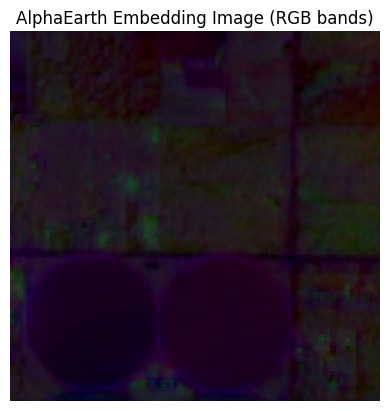

In [30]:
import rasterio
import matplotlib.pyplot as plt

tif_path = "/content/drive/MyDrive/gee_exports/alphaearth_image_0.tif"

# --- Read the GeoTIFF ---
with rasterio.open(tif_path) as src:
    print("CRS:", src.crs)
    print("Shape (bands, height, width):", src.count, src.height, src.width)
    img = src.read()  # Read all bands

# --- Visualize first 3 bands if available ---
if img.shape[0] >= 3:
    plt.imshow(img[:3].transpose(1, 2, 0))
    plt.title("AlphaEarth Embedding Image (RGB bands)")
    plt.axis("off")
    plt.show()
else:
    plt.imshow(img[0], cmap='gray')
    plt.title("Single-band image")
    plt.axis("off")
    plt.show()


In [27]:
pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 43.8 MB/s eta 0:00:00
